In [945]:
import numpy as np
import pandas as pd
import scipy.stats as stat
import matplotlib.pyplot as plt
from tqdm import tqdm

# TP2 Simulation d'actifs financiers.

# Exercice 1

En $t=0$ le prix de l'option est $$e^{-rT}\mathbb{E}\left[\left( S_T - K \right)^+\right]$$.

Et la dynamique de $(S_t)_t$ est donnée par $$dS_t=rS_t\operatorname{d}t\, + \sigma S_t\operatorname{d}W_t$$

Et on peut discrétiser (Euler-Maruyama) : 

\begin{equation*}
S_{t_{i+1}} = S_{t_i}\left[ 1 + rh + \sqrt{h}\sigma Z \right]
\end{equation*}

Avec $Z\sim\mathcal{N}(0, 1)$ et $h=t_{i+1}-t_{i}$

In [946]:
N, n, K, S_0, r, sigma, mu, T = 100, 1000, 800, 1000, 0.05, 0.2, 0.1, 1

In [947]:
def C_mc(N=N, n=n, K=K, S_0=S_0, r=r, sigma=sigma, mu=mu, T=T):

    S = np.full(n, S_0)
    h = T/N

    for i in range(N):
        Z = np.random.normal(0, 1, n)
        S = S * (r * h + np.sqrt(h) * sigma * Z + 1)

    pay_off = np.maximum(S - K, 0) 

    C = np.exp(-r * T) * np.mean( pay_off )

    return C, 2 * 1.96 * np.std(pay_off)/np.sqrt(n) #Donne la taille de l'intervalle de confiance


In [948]:
conf_mc = np.zeros(11)
C_estime = np.zeros(11)

In [949]:
C_estime, conf_mc = zip(*[C_mc(N=i) for i in tqdm(range(100, 10_000, 100))])

100%|██████████| 99/99 [00:20<00:00,  4.72it/s]


In [950]:
print(np.var(C_estime), np.mean(conf_mc))

42.862151870162805 25.01934902529748


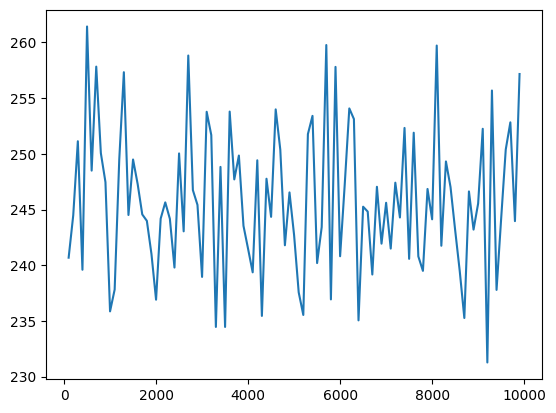

In [951]:
plt.plot(range(100, 10_000, 100), C_estime)
plt.show()

Le schéma de Milstein donne :

\begin{equation*}
S_{h(j+1)}=S_{hj}\left[1 +h \left(\operatorname{drift} + \frac12 \sigma^2 (Z^2-1)\right)+\sqrt{h}\sigma Z\right]
\end{equation*}

In [952]:
def C_mc_mil(N=N, n=n, K=K, S_0=S_0, r=r, sigma=sigma, mu=mu, T=T):
    S = np.full(n, S_0)
    h = T/N

    for i in range(N):
        Z = np.random.normal(0, 1, n)
        S = S * (1 + h * (r + 0.5 * sigma**2 * (Z ** 2 - 1)) + np.sqrt(h) * sigma * Z)

    pay_off = np.maximum(S - K, 0) 
    C = np.exp(-r * T) * np.mean( pay_off )

    return C, 2 * 1.96 * np.std(pay_off)/np.sqrt(n)

In [953]:
conf_mc_mil = np.zeros(11)
C_estime_mil = np.zeros(11)

In [954]:
C_estime_mil, conf_mc_mil = zip(*[C_mc_mil(N=i) for i in tqdm(range(100, 10_000, 100))])

100%|██████████| 99/99 [00:24<00:00,  3.98it/s]


In [955]:
print(np.var(C_estime_mil), np.mean(conf_mc))

34.66401234184757 25.01934902529748


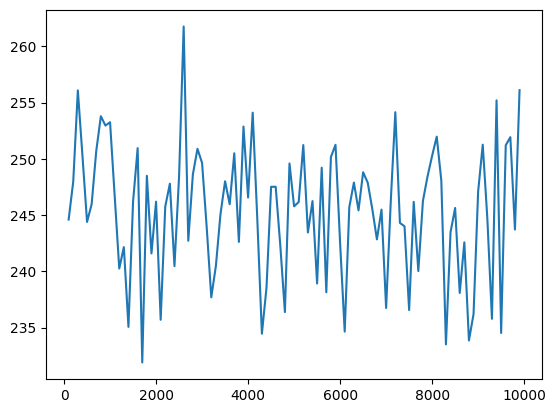

In [956]:
plt.plot(range(100, 10_000, 100), C_estime_mil)
plt.show()

In [957]:
N = 1000

In [958]:
C_estime_mil, conf_mc_mil = zip(*[C_mc_mil(n=i) for i in tqdm(range(1000, 5000, 10))])
C_estime, conf_mc = zip(*[C_mc(n=i) for i in tqdm(range(1000, 5000, 10))])

100%|██████████| 400/400 [00:03<00:00, 106.12it/s]


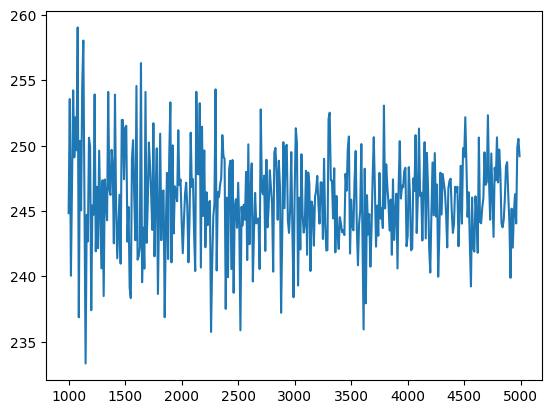

In [959]:
plt.plot(range(1000, 5000, 10), C_estime)
plt.show()

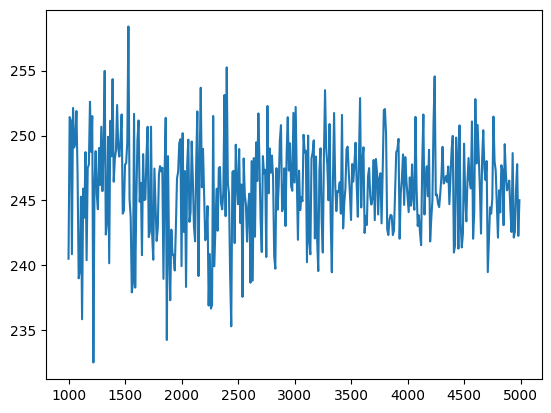

In [960]:
plt.plot(range(1000, 5000, 10), C_estime_mil)
plt.show()

In [961]:
C_estime_mil_N, conf_mc_mil_N = zip(*[C_mc_mil(N=10_000, n=1000) for _ in tqdm(range(50))])
C_estime_N, conf_mc_N = zip(*[C_mc(N=10_000, n=1000) for _ in tqdm(range(50))])

100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


In [962]:
print(f"Pour le schema de Milstein : Var = {np.var(C_estime_mil_N)}, Largeur IC = {np.mean(conf_mc_mil_N)}\n", f"Pour EM : Var = {np.var(C_estime_N)}, Largeur IC = {np.mean(conf_mc_N)}")

Pour le schema de Milstein : Var = 35.986584471712156, Largeur IC = 24.93183904867429
 Pour EM : Var = 34.208219906400025, Largeur IC = 24.950725437985497


In [963]:
C_estime_mil, conf_mc_mil = zip(*[C_mc_mil(N=1000, n=5000) for _ in tqdm(range(50))])
C_estime, conf_mc = zip(*[C_mc(N=1000, n=5000) for _ in tqdm(range(50))])

100%|██████████| 50/50 [00:07<00:00,  6.80it/s]


In [964]:
print(f"Pour le schema de Milstein : Var = {np.var(C_estime_mil)}, Largeur IC = {np.mean(conf_mc_mil)}\n", f"Pour EM : Var = {np.var(C_estime)}, Largeur IC = {np.mean(conf_mc)}")

Pour le schema de Milstein : Var = 7.521843195754983, Largeur IC = 11.138316542397723
 Pour EM : Var = 10.129580615339291, Largeur IC = 11.16181185321708


On divise la variance par quasiment 4 dans les deux cas donc le paramètre qui influence le plus l'estimation semble être le nombre de simulation plus que la précision du schéma employé.

In [965]:
def BS_Call(S_0=S_0, K=K, r=r, sigma=sigma, T=T):
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return S_0 * stat.norm.cdf(d1) - K * np.exp(-r * T) * stat.norm.cdf(d2)

In [966]:
print(f"EM = {C_mc(N=1000, n=5000)[0]} \n Mil = {C_mc_mil(N=1000, n=5000)[0]} \n BS = {BS_Call()}")

EM = 245.71450642600936 
 Mil = 248.74419768719943 
 BS = 245.88835443927746


\begin{align*}
dS_t = S_t(r dt + \sigma dW_t) ~~~\Longrightarrow ~~~ \frac{dS_t}{S_t} = rdt+\sigma dW_t ~~~\Longrightarrow~~~ d\ln{S_t} = \left(r-\frac{\sigma^2}{2}\right)dt+\sigma dW_t
\end{align*}

Ce qui peut se résoudre à la main avec :

\begin{equation*}
S_t = \ln{(S_0)} e^{\left( r-\frac{\sigma^2}{2} \right)t + \sigma W_t}
\end{equation*}

In [967]:
def PDD(n, N, S_0, S_a, T, r, sigma):

    h = T/N
    X = np.zeros((n, N + 1))
    X[:, 0] = np.log(S_0)
    Z = np.random.normal(0, 1, (n, N))

    for i in range(N):
        X[:, i + 1] = X[:, i] + (r - sigma**2 /2) * h + sigma * np.sqrt(h) * Z[:, i]

    S = np.exp(X)
    j0 = int(np.ceil(N * 0.5))

    S_T = S[:, -1]
    
    f_S = np.exp(-r * T) * (S_a - S_T) * (S_T <= 0.8 * S_a) * (np.max(S[:, j0:], axis=1) <= S_a)

    return np.mean(f_S), 2 * 1.96 * np.std(f_S)/np.sqrt(n)


In [968]:
PDD(1000, 2, 100, 120, 1, 0.03, 0.45)

(np.float64(25.013038444197264), np.float64(3.3785245121602587))

In [969]:
df1 = pd.DataFrame({
    'n': np.arange(1000, 100_001, 2_500),
    'Estimation': [PDD(i, 200, 100, 120, 1, 0.03, 0.45)[0] for i in tqdm(range(1000, 100_001, 2_500))]
})

100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


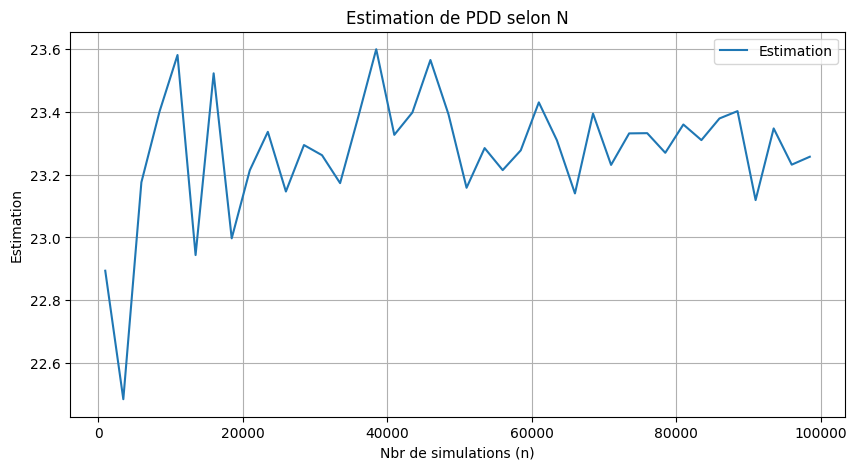

In [970]:
df1.plot(x='n', figsize=(10, 5), title="Estimation de PDD selon N")
plt.xlabel("Nbr de simulations (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.show()

In [971]:
df2 = pd.DataFrame({
    'n': np.arange(1000, 100_001, 10_000),
    'Estimation N = 200': [PDD(i, 200, 100, 120, 1, 0.03, 0.45)[0] for i in tqdm(range(1000, 100_001, 10_000))],
    'Estimation N = 1 000':[PDD(i, 1000, 100, 120, 1, 0.03, 0.45)[0] for i in tqdm(range(1000, 100_001, 10_000))]
})

100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


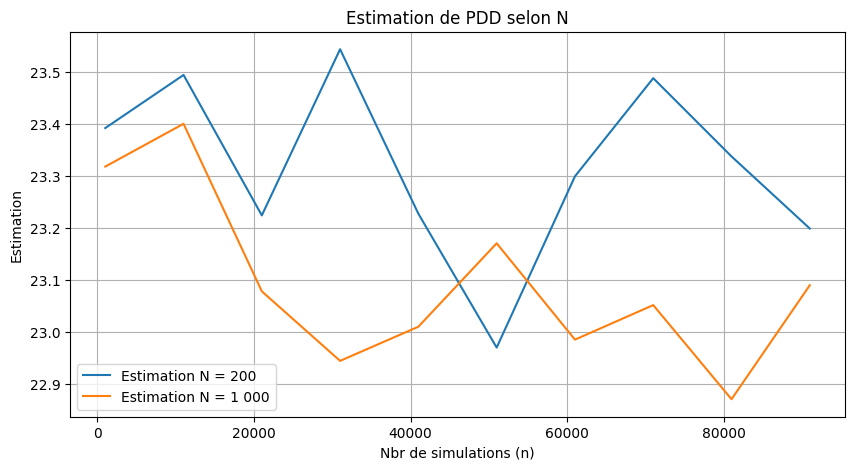

In [972]:
df2.plot(x='n', figsize=(10, 5), title="Estimation de PDD selon N")
plt.xlabel("Nbr de simulations (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.show()

In [973]:
estime_1, IC_1 = zip(*[PDD(1000, 200, 100, 120, 1, 0.03, 0.45) for _ in tqdm(range(250))])
estime_2, IC_2 = zip(*[PDD(1000, 1000, 100, 120, 1, 0.03, 0.45) for _ in tqdm(range(250))])

100%|██████████| 250/250 [00:12<00:00, 19.59it/s]


In [974]:
print(f"N = 200 -- Moyenne IC : {np.mean(IC_1)} Variance PDD : {np.var(estime_1)} \nN = 1 000 -- Moyenne IC : {np.mean(IC_2)} Variance PDD : {np.var(estime_2)}")

N = 200 -- Moyenne IC : 3.4795734286720883 Variance PDD : 0.8040296600759967 
N = 1 000 -- Moyenne IC : 3.4864426444485352 Variance PDD : 0.7708067469730454


On constate donc que la variance de l'estimation ainsi que la taille de l'intervalle de confiance ne changent pas énormément selon que l'on prenne un pas de temps de 200 ou 1000.

In [975]:
def PDD_ponts(n, N, S_0, S_a, T, r, sigma):

    h = T/N
    X = np.zeros((n, N + 1))
    X[:, 0] = np.log(S_0)
    Z = np.random.normal(0, 1, (n, N))

    for i in range(N):
        X[:, i + 1] = X[:, i] + (r - sigma**2 /2) * h + sigma * np.sqrt(h) * Z[:, i]

    S = np.exp(X)
    j0 = int(np.ceil(N/2))

    S_T = S[:, -1]

    L = np.log(S_a)
    x = X[:, j0:-1]
    y = X[:, j0+1:]
    p_k = np.exp(-2 * (x - L) * (y - L) / (sigma**2 * h))
    U = np.random.uniform(0, 1, p_k.shape)

    
    f_S = np.exp(-r * T) * (S_a - S_T) * (S_T <= 0.8 * S_a) * np.all(U > p_k, axis=1)

    return np.mean(f_S), 2 * 1.96 * np.std(f_S)/np.sqrt(n)

In [976]:
PDD_ponts(1000, 200, 100, 120, 1, 0.03, 0.45)

(np.float64(24.47243117261875), np.float64(3.553206904270247))

In [977]:
estime, IC = zip(*[PDD(i, 200, 100, 120, 1, 0.03, 0.45) for i in tqdm(range(100, 10_000, 10))])
estime_ponts, IC_ponts = zip(*[PDD_ponts(i, 200, 100, 120, 1, 0.03, 0.45) for i in tqdm(range(100, 10_000, 10))])

100%|██████████| 990/990 [00:57<00:00, 17.35it/s] 


In [978]:
df = pd.DataFrame({
    "n": range(100, 10_000, 10),
    "Estime": estime,
    "Estime Ponts": estime_ponts
})

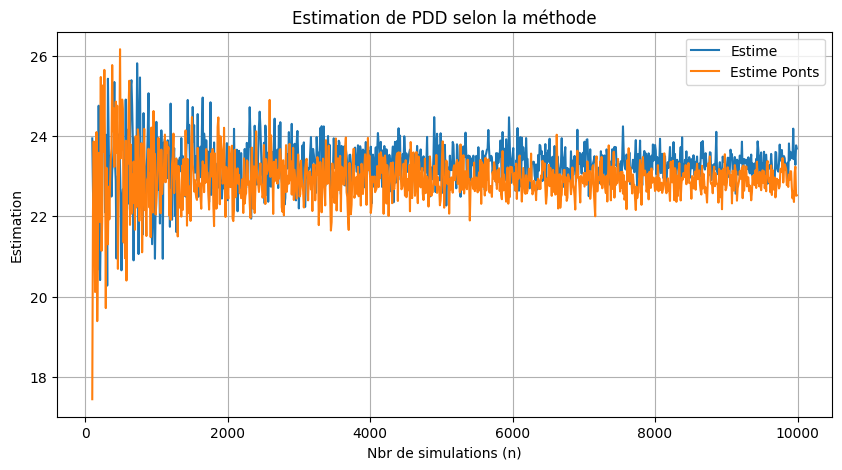

In [979]:
df.plot(x='n', figsize=(10, 5), title="Estimation de PDD selon la méthode")
plt.xlabel("Nbr de simulations (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.show()

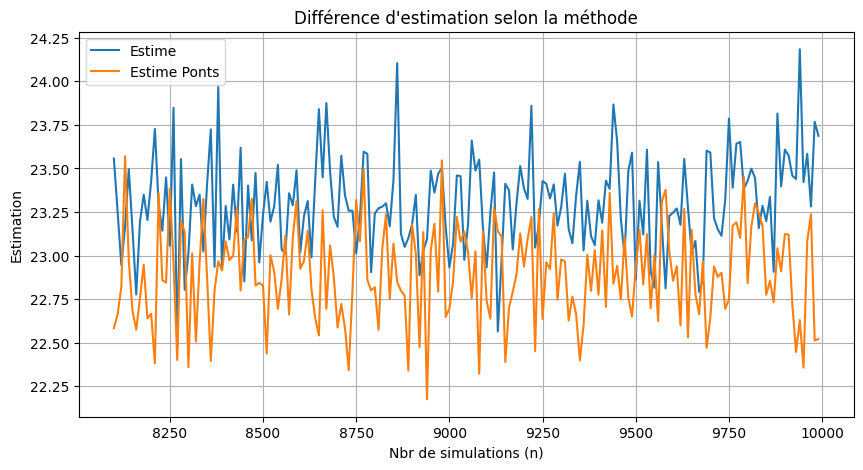

In [980]:
pd.DataFrame({
    "n": range(100, 10_000, 10)[800:],
    "Estime": estime[800:],
    "Estime Ponts": estime_ponts[800:]
}).plot(x='n', figsize=(10, 5), title="Différence d'estimation selon la méthode")
plt.xlabel("Nbr de simulations (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.show()

In [981]:
estime, IC = zip(*[PDD(i, 200, 100, 120, 1, 0.03, 0.45) for i in tqdm(range(1000, 100_000, 1000))])
estime_ponts, IC_ponts = zip(*[PDD_ponts(i, 200, 100, 120, 1, 0.03, 0.45) for i in tqdm(range(1000, 100_000, 1000))])

100%|██████████| 99/99 [01:16<00:00,  1.30it/s]


In [982]:
df = pd.DataFrame({
    "n": range(1000, 100_000, 1000),
    "Estime": estime,
    "Estime Ponts": estime_ponts
})

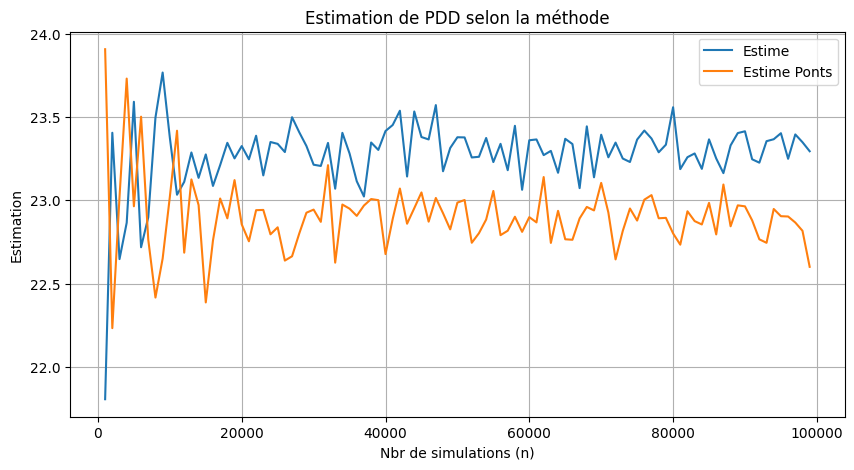

In [983]:
df.plot(x='n', figsize=(10, 5), title="Estimation de PDD selon la méthode")
plt.xlabel("Nbr de simulations (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.show()

On voit qu'avec le raffinement brownien on est systématiquement en dessous de la méthode sans raffinement.

In [984]:
def simCholesky(n, rho):
    Sigma = np.array([[1, rho], [rho, 1]])
    return np.random.multivariate_normal(np.zeros(2), Sigma, n)

In [1021]:
def PDD_2(n, N, S_0, S_a, T, r, sigma, rho):
    S_0, S_a, r, sigma = np.array(S_0), np.array(S_a), np.array(r), np.array(sigma) #S_0 = [S_0^1, S_0^2], idem pour S_a, les valeurs peuvent être différentes, idem pour r et sigma.
    h = T/N

    X = np.zeros((n, N + 1, 2))
    X[:, 0, :] = np.log(S_0)
    Z = simCholesky((n, N), rho)

    for i in range(N):
        X[:, i + 1, :] = X[:, i, :] + (r - sigma**2 /2) * h + sigma * np.sqrt(h) * Z[:, i, :]
    
    S = np.exp(X)
    S_T = S[:, -1, :]

    j0 = int(np.ceil(N/2))

    

    f_S = np.exp(-r * T) * (S_a - S_T) * (S_T <= 0.8 * S_a) * np.all(S[:, j0:, :] <= S_a, axis=1)
    PDD_1 = f_S[:, 0]
    PDD_2 = f_S[:, 1]

    return np.mean(PDD_1), np.mean(PDD_2)

In [1022]:
n_values = list(range(1000, 10001, 100))
PDD_1_list, PDD_2_list = zip(*[PDD_2(n, 200, [100, 110], [120, 120], 1, [0.03, 0.03], [0.45, 0.45], 0.3) for n in tqdm(n_values)])

100%|██████████| 91/91 [00:16<00:00,  5.60it/s]


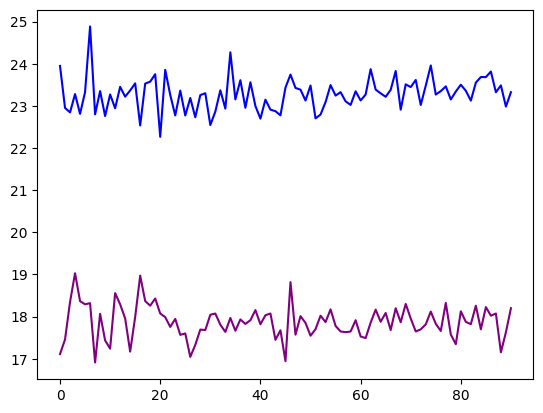

In [1023]:
plt.plot(PDD_1_list, color="blue")
plt.plot(PDD_2_list, color="purple")
plt.show()

In [1001]:
def PDD_2_ponts(n, N, S_0, S_a, T, r, sigma, rho):
    S_0, S_a, r, sigma = np.array(S_0), np.array(S_a), np.array(r), np.array(sigma) #S_0 = [S_0^1, S_0^2], idem pour S_a, les valeurs peuvent être différentes, idem pour r et sigma.
    h = T/N

    X = np.zeros((n, N + 1, 2))
    X[:, 0, :] = np.log(S_0)
    Z = simCholesky((n, N), rho)

    for i in range(N):
        X[:, i + 1, :] = X[:, i, :] + (r - sigma**2 /2) * h + sigma * np.sqrt(h) * Z[:, i, :]
    
    S = np.exp(X)
    S_T = S[:, -1, :]

    j0 = int(np.ceil(N/2))

    L = np.log(S_a)
    x = X[:, j0:-1, :]
    y = X[:, j0 + 1:, :]

    p_k = np.exp(-2 * (x - L) * (y - L) / (sigma**2 * h))
    U = np.random.uniform(0, 1, p_k.shape)

    f_S = np.exp(-r * T) * (S_a - S_T) * (S_T <= 0.8 * S_a) * np.all(U > p_k, axis=1)
    PDD_1 = f_S[:, 0]
    PDD_2 = f_S[:, 1]

    return np.mean(PDD_1), np.mean(PDD_2)

In [1030]:
n_values = list(range(1000, 10001, 100))
PDD_1_list, PDD_2_list = zip(*[PDD_2(n, 200, [100, 110], [120, 120], 1, [0.03, 0.03], [0.45, 0.45], 0.3) for n in tqdm(n_values)])
PDD_1_ponts_list, PDD_2_ponts_list = zip(*[PDD_2_ponts(n, 200, [100, 110], [120, 120], 1, [0.03, 0.03], [0.45, 0.45], 0.3) for n in tqdm(n_values)])

100%|██████████| 91/91 [00:18<00:00,  4.95it/s]


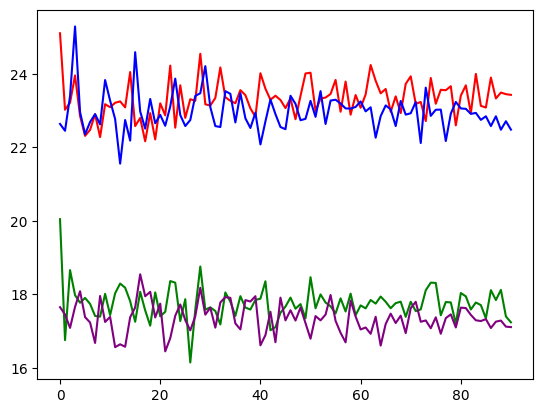

In [1031]:
plt.plot(PDD_1_list, color="red")
plt.plot(PDD_2_list, color="green")
plt.plot(PDD_1_ponts_list, color="blue")
plt.plot(PDD_2_ponts_list, color="purple")
plt.show()

rho = -0.8: 100%|██████████| 91/91 [00:18<00:00,  5.05it/s]


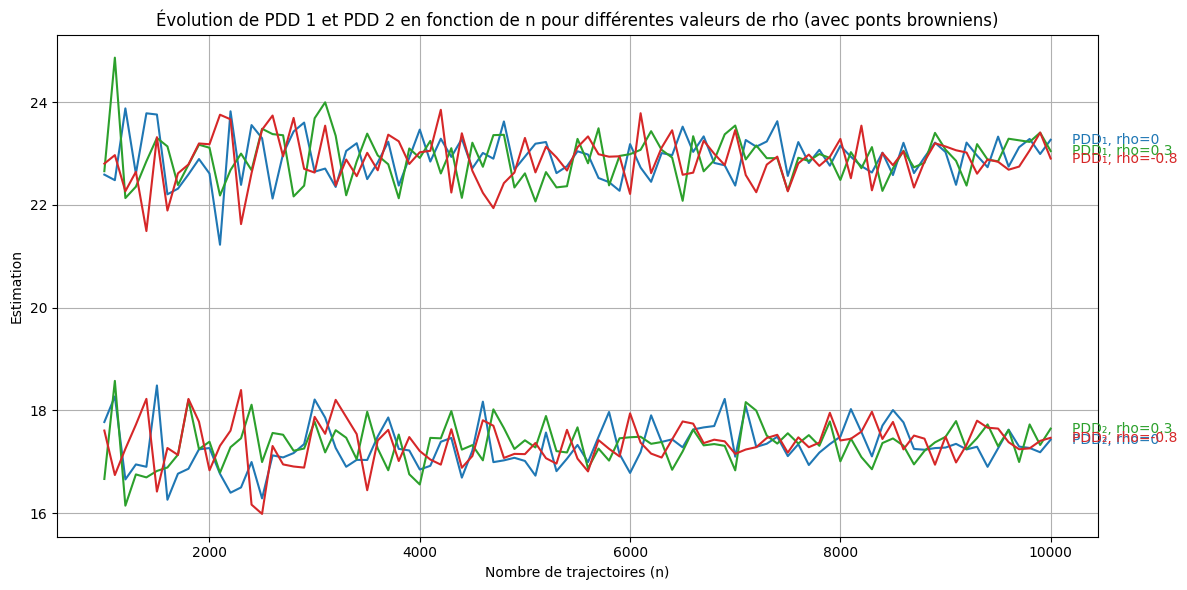

In [1032]:
colors = {
    0: 'tab:blue',
    0.3: 'tab:green',
    -0.8: 'tab:red'
}

n_values = list(range(1000, 10001, 100))
plt.figure(figsize=(12, 6))

for rho in [0, 0.3, -0.8]:
    PDD_1_ponts_list, PDD_2_ponts_list = zip(*[
        PDD_2_ponts(n, 200, [100, 110], [120, 120], 1, [0.03, 0.03], [0.45, 0.45], rho)
        for n in tqdm(n_values, desc=f"rho = {rho}")
    ])
    
    color = colors[rho]
    
    # Trace les deux courbes avec la même couleur
    plt.plot(n_values, PDD_1_ponts_list, color=color)
    plt.plot(n_values, PDD_2_ponts_list, color=color)
    
    # Ajoute un label à la fin de chaque courbe
    plt.text(n_values[-1] + 200, PDD_1_ponts_list[-1], f'PDD₁, rho={rho}', color=color, va='center')
    plt.text(n_values[-1] + 200, PDD_2_ponts_list[-1], f'PDD₂, rho={rho}', color=color, va='center')

plt.title("Évolution de PDD 1 et PDD 2 en fonction de n pour différentes valeurs de rho (avec ponts browniens)")
plt.xlabel("Nombre de trajectoires (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.tight_layout()
plt.show()
